# Computer Vision: Building and Fine Tuning CNNs
### Erkin Polat

In this project, I will build a CNN (Convolutional Neural Network) with Keras to classify whether a person is wearing a facemask or not.

I will start with a simple CNN architecture and fine tune its hyperparameters to get the best performance. The experiments I am running will be with different activation functions for the dense layers, different optimizers and different dropout rates. I will use training and validation losses to inspect these different hyperparameters. Then I will build a final model with the findings on my experiments and check how it performs on previously unseen test data. 

In the next section, I will build a clone of the VGG16 model using keras library. I will train that on the same data as well and compare the performances of my own model and the VGG16 model. It's unlikely that VGG16 will perform well on small datasets with low epochs, however, I believe it will give us important findings to dicuss.

In [1]:
#Mounting Google Drive

In [2]:
from google.colab import drive

In [160]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
#Installing dependencies

In [162]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [163]:
#Preparing Data

In [164]:
#Defining the directories for the different data. To download the dataset yourself go to: https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset
base_dir = '/content/drive/My Drive/classification/New Masks Dataset'
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')
validation_dir = os.path.join(base_dir, 'Validation')

In [165]:
#Getting the data from drive. I use Keras's ImageDataGenerator objects for getting the data and preprocessing it.
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=8,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=8,
    class_mode='binary'
)

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# Building the Initial Model

Model architecture:

Input

-----------------
(Convolution Block 1)<br>
Convolution Layer (16, (3,3)<br>
Convolution Layer (16, (3,3)<br>
MaxPooling (2,2)

-----------------
(Convolution Block 2)<br>
Convolution Layer (32, (3,3)<br>
Convolution Layer (32, (3,3)<br>
MaxPooling (2,2)

-----------------
(Classification Block)<br>
Fully Connected Layer<br>
Fully Connected Layer

Output Layer

As it can be seen above, I used two convolutional blocks, that each consist of 2 convolutional layers and a pooling layer afterwards. I added 2 convolutional layers within each block because that was a trend I often encountered with robust models such as VGG19. After the convolutions there are pooling layers to downsize the information being passed. I chose max pooling in my model, as it usually extracts features better than average pooling. I also add a relu activation to each convolutional layer to keep the inputs positive. This is a trick I read about recently.

After the convolution blocks, I have block of layers for the classification. Here I used two fully connected layers and then an output layer. I added dropout between the two dense layers to reduce overtraining. I later on experiment with this parameter.

In [166]:
#I add this command in multiple places. It is to keep models from using too much space.
#Also, it prevents us from keeping putting more layers to a model we already built
keras.backend.clear_session()

In [167]:
#First we use the sequential class
model = Sequential()

#I continue with 2 convolutional layers
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(Conv2D(16, (3,3), activation='relu'))

#Adding the first pooling layer
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#Adding 2 more convolutions
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))

#Adding the second pooling
model.add(MaxPool2D(pool_size=(2,2)))

#Flattening the convolution output
model.add(Flatten())

#Feeding the flattened output into a dense layer
model.add(Dense(64, activation='relu'))

#Adding dropout of 50%
model.add(Dropout(0.5))

#Adding another dense layer
model.add(Dense(32, activation='relu'))

#Adding the output layer
model.add(Dense(1, activation='sigmoid'))

In [168]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 119072)            0

In [169]:
#Here I compile and train my model. I start with the adam optimizer, but I'll try different ones
#I use bineray crossentropy loss since it is a binary classification problem.

model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

base_history = model.fit(
    train_generator, 
    steps_per_epoch=10, 
    epochs=30, 
    validation_data=validation_generator, 
    validation_steps=6)

Epoch 1/30
10/10 [==============================] - 4s 368ms/step - loss: 1.2447 - accuracy: 0.5317 - val_loss: 0.7597 - val_accuracy: 0.5208
Epoch 2/30
10/10 [==============================] - 3s 334ms/step - loss: 0.7129 - accuracy: 0.5543 - val_loss: 0.4923 - val_accuracy: 0.7292
Epoch 3/30
10/10 [==============================] - 3s 349ms/step - loss: 0.4186 - accuracy: 0.8241 - val_loss: 0.4798 - val_accuracy: 0.7708
Epoch 4/30
10/10 [==============================] - 3s 355ms/step - loss: 0.4329 - accuracy: 0.7791 - val_loss: 0.3957 - val_accuracy: 0.9167
Epoch 5/30
10/10 [==============================] - 3s 322ms/step - loss: 0.3401 - accuracy: 0.8517 - val_loss: 0.5676 - val_accuracy: 0.8125
Epoch 6/30
10/10 [==============================] - 3s 340ms/step - loss: 0.7382 - accuracy: 0.8036 - val_loss: 0.2121 - val_accuracy: 0.9583
Epoch 7/30
10/10 [==============================] - 3s 332ms/step - loss: 0.3186 - accuracy: 0.8663 - val_loss: 0.2201 - val_accuracy: 0.9167
Epoch 

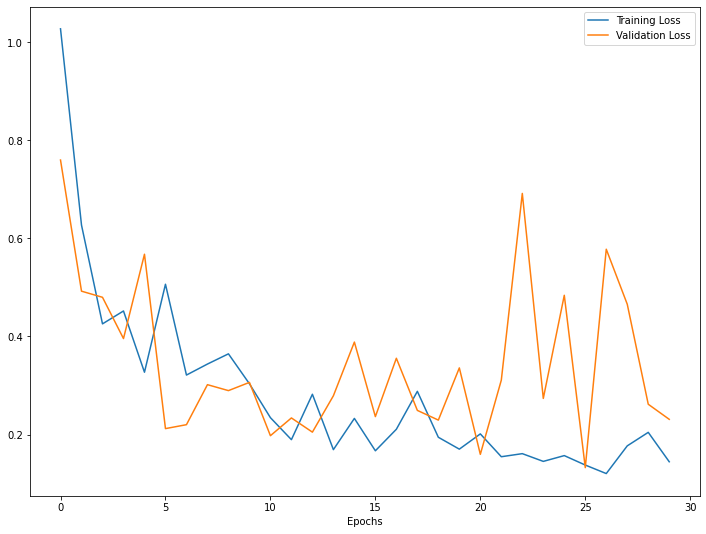

In [170]:
#Plotting the training and validation losses
plt.figure(figsize=(12, 9))
plt.plot(base_history.history['loss'], label='Training Loss')
plt.plot(base_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Here we can see that the training loss is constantly minimized, while there are fluctuations in the validation loss. The fluctuations in the validation loss could be due to multiple reasons. One possibility is that it is already pretty good after the early training (the whole time it's below 1), therefore, it doesn't really get much better later on. We will account for this later on by adding an early stop callback to our final model. Another reason could be because we're working with a rather small dataset, therefore, the model might be overfitting after a while. The early stopping should account for this too, but we will also fine tune the dropout hyperparameter to tackle this. To improve the performance let's first experiment with different activation functions and different optimizers.

# Experimenting with Different Hyperparameters

First let's define functions to help us do the visualization for the comparisons.

In [171]:
#Function to plot validation losses

def plot_loss(base, hist, baseline_label, labels):
  plt.figure(figsize=(12, 9))
  plt.plot(base.history['loss'], label=baseline_label)
  for i in range(len(labels)):
    plt.plot(hist[i].history['loss'], label=labels[i])
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

def plot_val_loss(base, hist, baseline_label, labels):
  plt.figure(figsize=(12, 9))
  plt.plot(base.history['val_loss'], label=baseline_label)
  for i in range(len(labels)):
    plt.plot(hist[i].history['val_loss'], label=labels[i])
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

## Trying sigmoid instead of relu

I will try replacing the relu activation functions with the sigmoid function in the dense layers.

In [172]:
keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(Conv2D(16, (3,3), activation='relu'))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='loss', patience=10)

model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

sigmoid_history = model.fit(
    train_generator, 
    steps_per_epoch=10, 
    epochs=30, 
    validation_data=validation_generator, 
    validation_steps=6, callbacks=[callback])

Epoch 1/30
10/10 [==============================] - 4s 368ms/step - loss: 0.7196 - accuracy: 0.5007 - val_loss: 0.6609 - val_accuracy: 0.7917
Epoch 2/30
10/10 [==============================] - 3s 359ms/step - loss: 0.6020 - accuracy: 0.7665 - val_loss: 0.5546 - val_accuracy: 0.8333
Epoch 3/30
10/10 [==============================] - 3s 308ms/step - loss: 0.5888 - accuracy: 0.7053 - val_loss: 0.5580 - val_accuracy: 0.7917
Epoch 4/30
10/10 [==============================] - 4s 378ms/step - loss: 0.4465 - accuracy: 0.9226 - val_loss: 0.4038 - val_accuracy: 0.8958
Epoch 5/30
10/10 [==============================] - 3s 329ms/step - loss: 0.4504 - accuracy: 0.8603 - val_loss: 0.4212 - val_accuracy: 0.8542
Epoch 6/30
10/10 [==============================] - 3s 290ms/step - loss: 0.3865 - accuracy: 0.8973 - val_loss: 0.3017 - val_accuracy: 0.9375
Epoch 7/30
10/10 [==============================] - 3s 355ms/step - loss: 0.3178 - accuracy: 0.9018 - val_loss: 0.3800 - val_accuracy: 0.8958
Epoch 

### Plotting the results

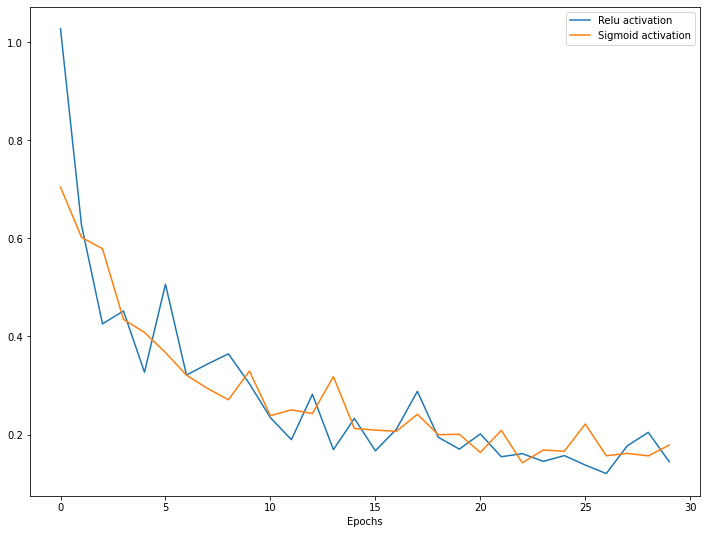

In [173]:
plot_loss(base_history, [sigmoid_history], 'Relu activation', ['Sigmoid activation'])

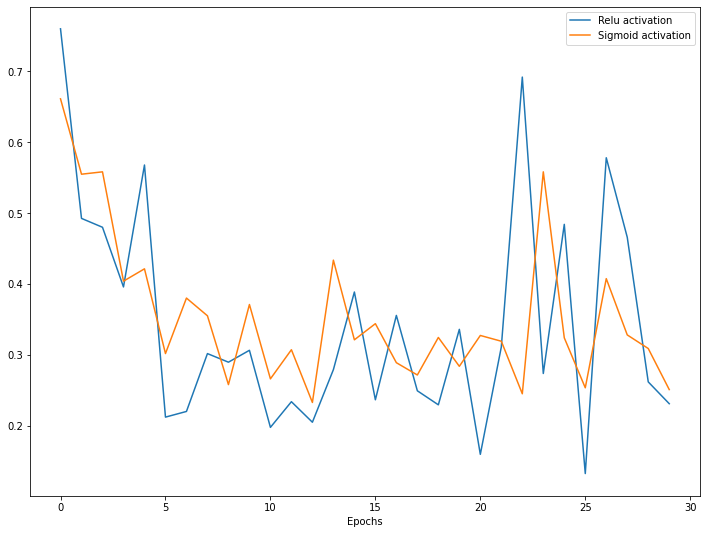

In [174]:
plot_val_loss(base_history, [sigmoid_history], 'Relu activation', ['Sigmoid activation'])

Looking at both the training and the validation losses, we can see that this is a close match with relu performing slightly better. In the training loss we saw that relu exceeds sigmoid in terms of performance after some epochs. The validation loss also suggests an earlier minimization with the relu activation function if we look at the performance until around epoch 15. After this the loss seems to be increasing, which suggests overfitting. Again, we will take this into acaunt later on. For now Relu is the winner.

# Experimenting with Different Optimizers

Our baseline model used the Adam optimizer. Now we will also utilize Adamax RMSprop and SGD optimizers to see how they perform against our baseline model.

In [175]:
#Creating an array with the optimizer names and an empty array to save the results
optimizers = ['Adamax', 'RMSprop', 'SGD']
optimizer_history=[]

In [176]:
#Clearing the backend
keras.backend.clear_session()

#looping over different optimizers
for i in range(len(optimizers)):

  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)))
  model.add(Conv2D(16, (3,3), activation='relu'))

  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(Conv2D(32, (3,3), activation='relu'))

  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  #callback = EarlyStopping(monitor='loss', patience=10)

  model.compile(
      loss='binary_crossentropy', 
      optimizer=optimizers[i], 
      metrics=['accuracy'])

  op_history = model.fit(
      train_generator, 
      steps_per_epoch=10, 
      epochs=30, 
      validation_data=validation_generator, 
      validation_steps=6)
  
  optimizer_history.append(op_history)

Epoch 1/30
10/10 [==============================] - 4s 346ms/step - loss: 1.8808 - accuracy: 0.5586 - val_loss: 0.6851 - val_accuracy: 0.5000
Epoch 2/30
10/10 [==============================] - 3s 340ms/step - loss: 0.6945 - accuracy: 0.5598 - val_loss: 0.6578 - val_accuracy: 0.5625
Epoch 3/30
10/10 [==============================] - 3s 325ms/step - loss: 0.6619 - accuracy: 0.5889 - val_loss: 0.6309 - val_accuracy: 0.8125
Epoch 4/30
10/10 [==============================] - 3s 324ms/step - loss: 0.6290 - accuracy: 0.7118 - val_loss: 0.5698 - val_accuracy: 0.8333
Epoch 5/30
10/10 [==============================] - 3s 321ms/step - loss: 0.5428 - accuracy: 0.7443 - val_loss: 0.4568 - val_accuracy: 0.9375
Epoch 6/30
10/10 [==============================] - 3s 326ms/step - loss: 0.4217 - accuracy: 0.8290 - val_loss: 0.3747 - val_accuracy: 0.9167
Epoch 7/30
10/10 [==============================] - 3s 322ms/step - loss: 0.3431 - accuracy: 0.8789 - val_loss: 0.3692 - val_accuracy: 0.8958
Epoch 

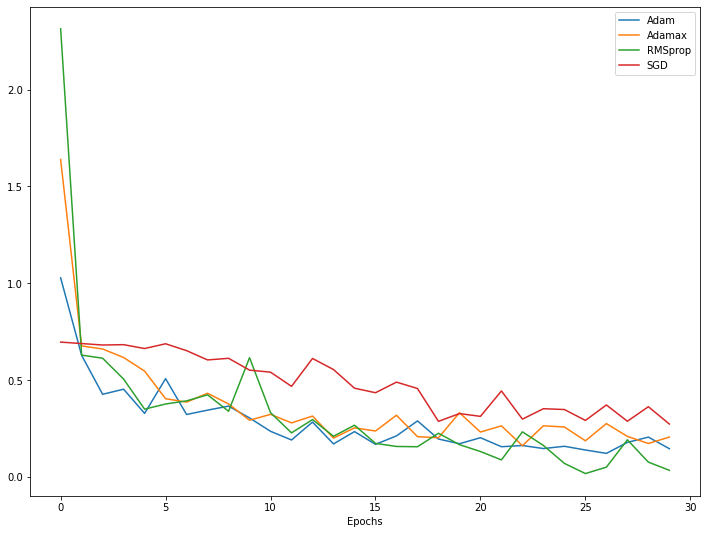

In [177]:
plot_loss(base_history, optimizer_history, 'Adam', optimizers)

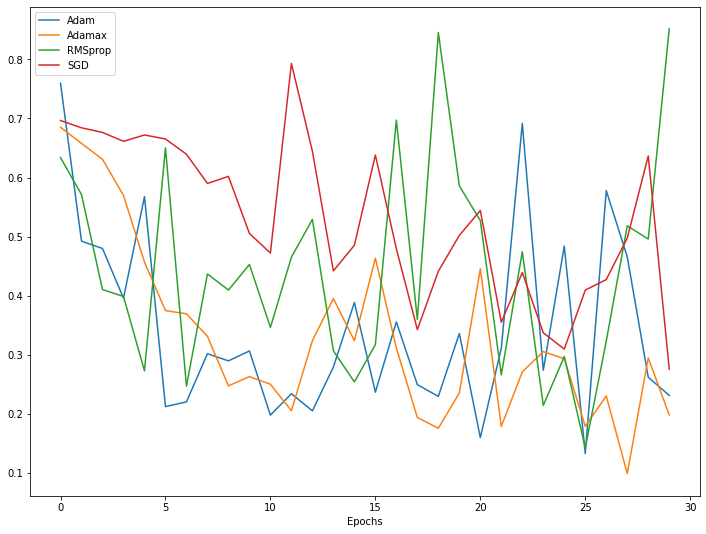

In [178]:
plot_val_loss(base_history, optimizer_history, 'Adam', optimizers)

Looking at the training dataset loss, we see that SGD performs the worst and the rest have a similar performance. In the validation data we also see that RMSprop and SGD have higher loss in general. It seems like Adamax is the best option out of the 4.

# Comparing Different Dropout Rates

Now we will look at how using different dropout rates can improve the model performace. The baseline model had a dropout rate of 50%. Let's take a look at how using differents rate will result.

In [179]:
dropouts = [0, 0.1, 0.2, 0.3, 0.4]
dropout_history=[]

In [180]:
for i in range(len(dropouts)):
  keras.backend.clear_session()

  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)))
  model.add(Conv2D(16, (3,3), activation='relu'))

  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(Conv2D(32, (3,3), activation='relu'))

  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropouts[i]))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  #callback = EarlyStopping(monitor='loss', patience=10)

  model.compile(
      loss='binary_crossentropy', 
      optimizer='adam', 
      metrics=['accuracy'])

  dropout_hist = model.fit(
      train_generator, 
      steps_per_epoch=10, 
      epochs=30, 
      validation_data=validation_generator, 
      validation_steps=6)
  
  dropout_history.append(dropout_hist)

Epoch 1/30
10/10 [==============================] - 4s 365ms/step - loss: 0.8219 - accuracy: 0.5618 - val_loss: 0.4762 - val_accuracy: 0.7083
Epoch 2/30
10/10 [==============================] - 3s 340ms/step - loss: 0.4033 - accuracy: 0.8268 - val_loss: 0.2924 - val_accuracy: 0.8542
Epoch 3/30
10/10 [==============================] - 3s 355ms/step - loss: 0.5289 - accuracy: 0.7216 - val_loss: 0.5054 - val_accuracy: 0.7292
Epoch 4/30
10/10 [==============================] - 3s 303ms/step - loss: 0.3938 - accuracy: 0.8499 - val_loss: 0.6448 - val_accuracy: 0.6875
Epoch 5/30
10/10 [==============================] - 3s 330ms/step - loss: 0.3465 - accuracy: 0.8606 - val_loss: 0.2079 - val_accuracy: 0.9167
Epoch 6/30
10/10 [==============================] - 3s 291ms/step - loss: 0.3155 - accuracy: 0.8625 - val_loss: 0.2610 - val_accuracy: 0.9167
Epoch 7/30
10/10 [==============================] - 3s 348ms/step - loss: 0.2031 - accuracy: 0.9073 - val_loss: 0.3550 - val_accuracy: 0.8958
Epoch 

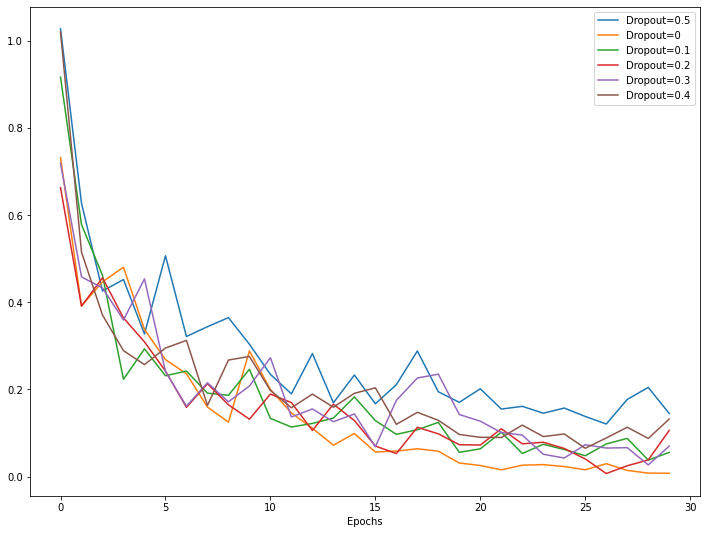

In [181]:
labels=[('Dropout=%s' %str(dropout)) for dropout in dropouts]
plot_loss(base_history, dropout_history, 'Dropout=0.5', labels)

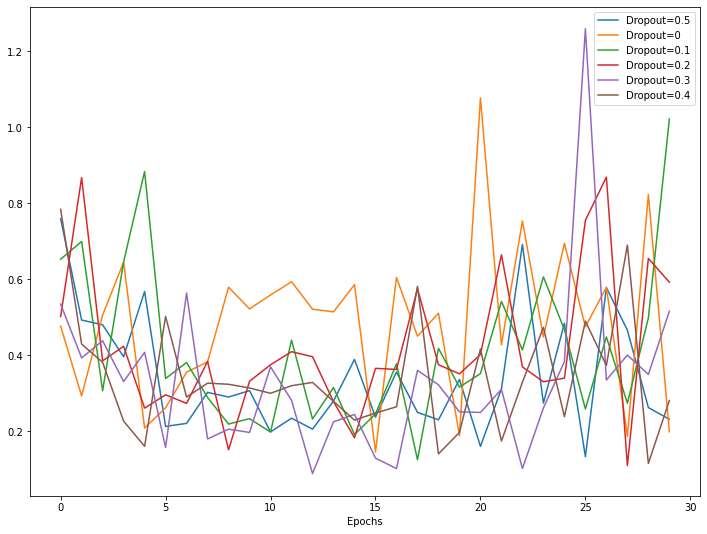

In [182]:
plot_val_loss(base_history, dropout_history, 'Dropout=0.5', labels)

Looking at the training loss, the lowever dropouts give better results, however, the purpose of using dropout is to prevent overfitting, so I won't take the training loss too much into account. The validation losses are a mess. One thing to realize is that both using 0 and 0.5 gives us higher variances over the loss. I wan't to aim for a constant reduction in loss. Using 0.3 seems like a good idea, as the loss always seems to be within a reasonable range and tends to decrease. Also, in the training data it performs similarly to higher dropouts.

# Building Our Final Model

Now that we have gained insight about how using some different parameters change the loss over the duration of training we can now put it all together to come up with a final model. We will use the relu activation function for the dense layers, Adamax for the optimizer, and a dropout rate of 0.3. On top of this, we will be introducing an early stopping if the validation loss doesn't improve after 10 epochs. This further ensures that we aren't overtraining the model and hopefully improves the performance on the test data.

In [183]:
keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(Conv2D(16, (3,3), activation='relu'))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [184]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 119072)            0

In [185]:
callback = EarlyStopping(monitor='loss', patience=10)

In [186]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='Adamax', 
    metrics=['accuracy'])

final_model_history = model.fit(
    train_generator, 
    steps_per_epoch=10, 
    epochs=100, 
    validation_data=validation_generator, 
    validation_steps=6, callbacks=[callback])

Epoch 1/100
10/10 [==============================] - 4s 369ms/step - loss: 0.7221 - accuracy: 0.5018 - val_loss: 0.6197 - val_accuracy: 0.5833
Epoch 2/100
10/10 [==============================] - 3s 328ms/step - loss: 0.4006 - accuracy: 0.8584 - val_loss: 0.2322 - val_accuracy: 0.8750
Epoch 3/100
10/10 [==============================] - 3s 318ms/step - loss: 0.2955 - accuracy: 0.9235 - val_loss: 0.3143 - val_accuracy: 0.8542
Epoch 4/100
10/10 [==============================] - 4s 350ms/step - loss: 0.2998 - accuracy: 0.9051 - val_loss: 0.2313 - val_accuracy: 0.8958
Epoch 5/100
10/10 [==============================] - 3s 359ms/step - loss: 0.2132 - accuracy: 0.9215 - val_loss: 0.2046 - val_accuracy: 0.8958
Epoch 6/100
10/10 [==============================] - 3s 305ms/step - loss: 0.1690 - accuracy: 0.9363 - val_loss: 0.3934 - val_accuracy: 0.8333
Epoch 7/100
10/10 [==============================] - 3s 305ms/step - loss: 0.1600 - accuracy: 0.9504 - val_loss: 0.1008 - val_accuracy: 0.9583

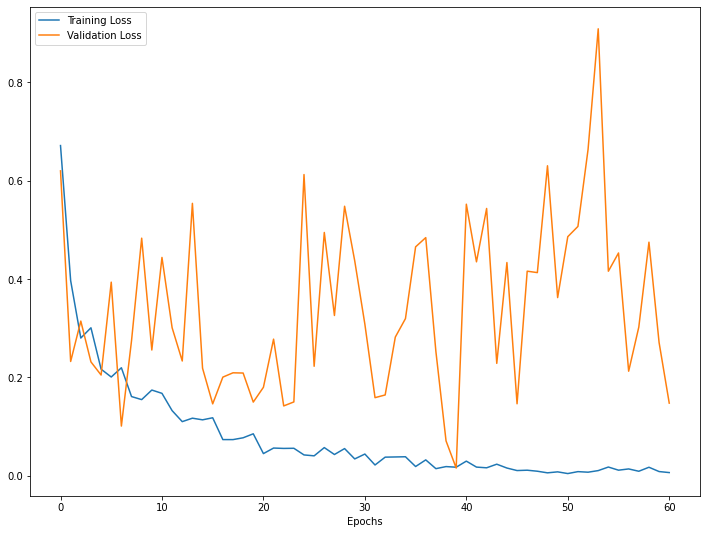

In [187]:
plt.figure(figsize=(12, 9))
plt.plot(final_model_history.history['loss'], label='Training Loss')
plt.plot(final_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [188]:
loss, acc = model.evaluate_generator(test_generator, steps=3, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [189]:
print("Test Loss: ", loss, "Test Accuracy: ", acc)

Test Loss:  0.1896378993988037 Test Accuracy:  0.9583333134651184


## Plotting some example images and their predicted labels

In [190]:
x= test_generator.next()
labels = model.predict(x[0])

In [191]:
str_labels=[]
for i in range(len(labels)):
  if labels[i]>0.5:
    str_labels.append("No Mask")
  else:
    str_labels.append("Mask")

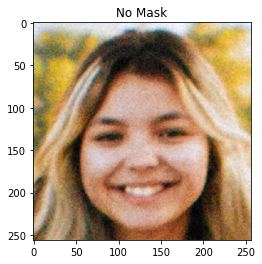

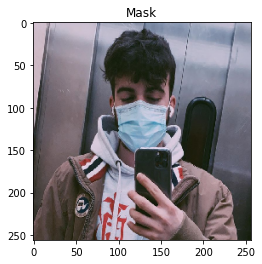

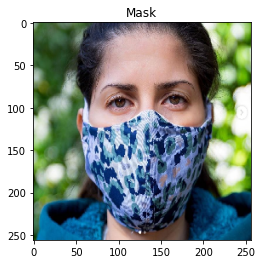

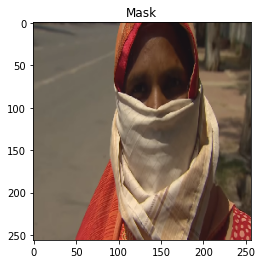

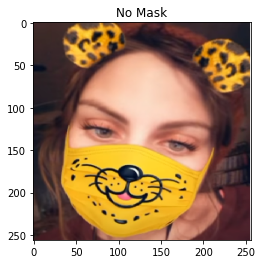

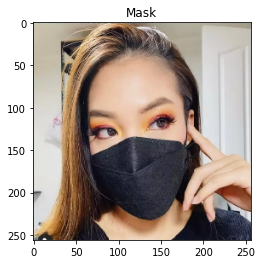

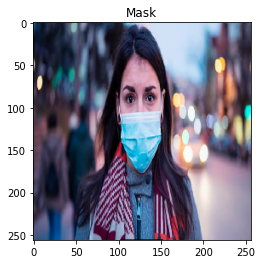

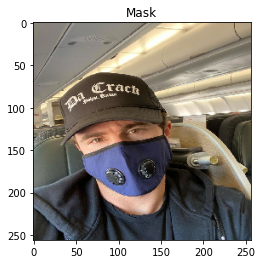

In [192]:
for i in range(0,8):
    image = x[0][i]
    plt.imshow(image)
    plt.title(str_labels[i])
    plt.show()

Our model is performing very well as can be seen from the test set accuracy of 95.83%. However, as you can see from the image of the lady with the yelow mask above, there are some edge cases that our model cannot predict very well. On her mask there is a mouthlike shape and this is likely why our models fails to predict that she is wearing a mask. Now let's see how our model performs compared to some famous models.

# Extension: Comparison against VGG16

Here, I will build a model that is close to the VGG16 architecture, and we will compare our model performance to the performance of VGG16 on the same dataset. Source used for the architecture: https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

In [143]:
keras.backend.clear_session()

In [144]:
VGG16 = Sequential()
VGG16.add(Conv2D(input_shape=(256,256,3),filters=64,kernel_size=(3,3),padding='same', activation='relu'))
VGG16.add(Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu'))
VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
VGG16.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
VGG16.add(Flatten())
VGG16.add(Dense(units=4096,activation='relu'))
VGG16.add(Dense(units=4096,activation='relu'))
VGG16.add(Dense(units=1, activation='sigmoid'))

In [145]:
VGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 256)       2

In [135]:
callback = EarlyStopping(monitor='loss', patience=20)

In [136]:
VGG16.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

VGG16_history = model.fit(
    train_generator, 
    steps_per_epoch=10, 
    epochs=300, 
    validation_data=validation_generator, 
    validation_steps=6, callbacks=[callback])

Epoch 1/300
10/10 [==============================] - 4s 365ms/step - loss: 0.4262 - accuracy: 0.8450 - val_loss: 0.4582 - val_accuracy: 0.8333
Epoch 2/300
10/10 [==============================] - 3s 329ms/step - loss: 0.4354 - accuracy: 0.7800 - val_loss: 0.5201 - val_accuracy: 0.7917
Epoch 3/300
10/10 [==============================] - 3s 352ms/step - loss: 0.3548 - accuracy: 0.8500 - val_loss: 0.5023 - val_accuracy: 0.6875
Epoch 4/300
10/10 [==============================] - 4s 368ms/step - loss: 0.3675 - accuracy: 0.8700 - val_loss: 0.3718 - val_accuracy: 0.8542
Epoch 5/300
10/10 [==============================] - 4s 361ms/step - loss: 0.3177 - accuracy: 0.8700 - val_loss: 0.5432 - val_accuracy: 0.7500
Epoch 6/300
10/10 [==============================] - 3s 340ms/step - loss: 0.4151 - accuracy: 0.8450 - val_loss: 0.5033 - val_accuracy: 0.7917
Epoch 7/300
10/10 [==============================] - 3s 355ms/step - loss: 0.4245 - accuracy: 0.8150 - val_loss: 0.3943 - val_accuracy: 0.8542

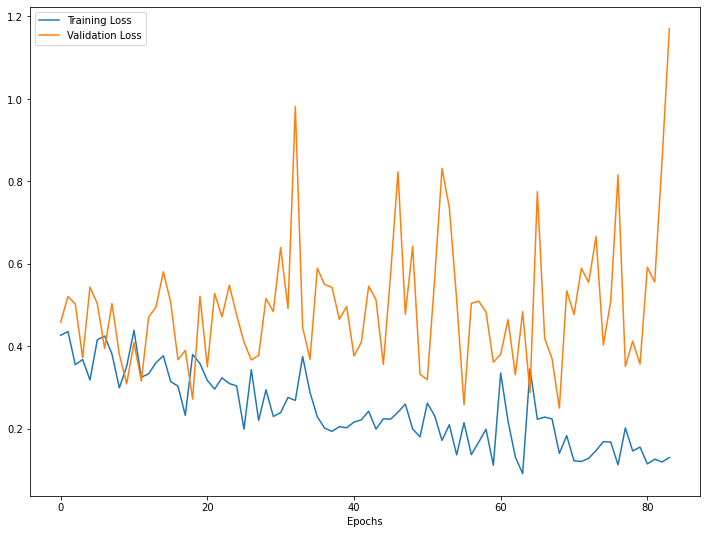

In [137]:
plt.figure(figsize=(12, 9))
plt.plot(VGG16_history.history['loss'], label='Training Loss')
plt.plot(VGG16_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [138]:
VGG16_loss, VGG16_acc = VGG16.evaluate_generator(test_generator, steps=3, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [139]:
print("Test Loss: ", VGG16_loss, "Test Accuracy: ", VGG16_acc)

Test Loss:  0.6932468414306641 Test Accuracy:  0.4166666567325592


The results are not satisfying. It's even worse than a random guess, but maybe we can improve them.

## Adding dropout to VGG16
Maybe we can improve on the results if we added dropout to the model. I am setting the dropout to be 0.5. We need it high as this is a model with a lot of parameters and we want to avoid overfitting as much as possible. I also reduce the early stopping to 10 epochs as I expect this model to have less overfitting during training anyway. 

In [146]:
keras.backend.clear_session()

In [148]:
VGG16 = Sequential()
VGG16.add(Conv2D(input_shape=(256,256,3),filters=64,kernel_size=(3,3),padding='same', activation='relu'))
VGG16.add(Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu'))
VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
VGG16.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
VGG16.add(Flatten())
VGG16.add(Dense(units=4096,activation='relu'))
VGG16.add(Dropout(0.5))
VGG16.add(Dense(units=4096,activation='relu'))
VGG16.add(Dense(units=1, activation='sigmoid'))

callback = EarlyStopping(monitor='loss', patience=20)

VGG16.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

VGG16_history = model.fit(
    train_generator, 
    steps_per_epoch=10, 
    epochs=300, 
    validation_data=validation_generator, 
    validation_steps=6, callbacks=[callback])

Epoch 1/300
10/10 [==============================] - 3s 324ms/step - loss: 0.1466 - accuracy: 0.9450 - val_loss: 0.6189 - val_accuracy: 0.8333
Epoch 2/300
10/10 [==============================] - 3s 347ms/step - loss: 0.1008 - accuracy: 0.9650 - val_loss: 0.6370 - val_accuracy: 0.8125
Epoch 3/300
10/10 [==============================] - 3s 319ms/step - loss: 0.1354 - accuracy: 0.9500 - val_loss: 0.5136 - val_accuracy: 0.8333
Epoch 4/300
10/10 [==============================] - 3s 343ms/step - loss: 0.1370 - accuracy: 0.9450 - val_loss: 0.8008 - val_accuracy: 0.7708
Epoch 5/300
10/10 [==============================] - 3s 282ms/step - loss: 0.0807 - accuracy: 0.9650 - val_loss: 0.7836 - val_accuracy: 0.8333
Epoch 6/300
10/10 [==============================] - 3s 352ms/step - loss: 0.0716 - accuracy: 0.9700 - val_loss: 0.8026 - val_accuracy: 0.7917
Epoch 7/300
10/10 [==============================] - 3s 354ms/step - loss: 0.1560 - accuracy: 0.9300 - val_loss: 0.7729 - val_accuracy: 0.8750

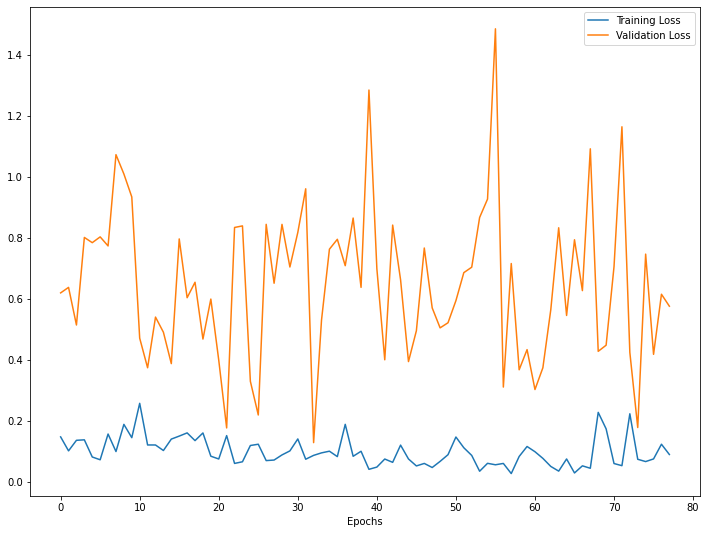

In [149]:
plt.figure(figsize=(12, 9))
plt.plot(VGG16_history.history['loss'], label='Training Loss')
plt.plot(VGG16_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [158]:
VGG16_loss, VGG16_acc = VGG16.evaluate_generator(test_generator, steps=3, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [159]:
print("Test Loss: ", VGG16_loss, "Test Accuracy: ", VGG16_acc)

Test Loss:  0.6931898593902588 Test Accuracy:  0.5416666865348816


# Discussing the Comparison of the Results

Adding the dropout slightly improved the results. However, our simpler CNN gives us a test accuracy or 95%, while the VGG16 clone's guesses are barely an improvement to a random guess. These results are rather disappointing and could be even because of some bad decisions while training the model, but I am confident that I built the model propoerly. There could be a couple reasons we are getting these results, mainly the small dataset and the high number of parameters in the model. The two are related. There are so many parameters in the model that we cannot train them in a meaningful way. To do so we would need much longer epochs, but at the same time we would need to feed the model a much bigger dataset. 

Nonetheless, I think these findings are extremely important. This illustrates the importance of the model architecture choices based on the kind of problem we are trying to tackle. Detection of whether someone is wearing a mask is a simple problem compared to what VGG16 is known to achieve. Of course propoerly training VGG16 would solve the problem at hand, but such complicated models need a very big amount of data to train from scratch and depending on the problem, we might not be able to afford that. Instead, we can go with a model that is just complicated enough for the problem at hand. Of course this is not really a quantifiable thing, as you might "ask what is enough complexity?". Maybe a less complex model would have performed even better than our initial model and we can't really quantitatively assess this before training. Here, our intuition and experience plays a big role in deciding on an initial model, however, experimenting with different architectures and hyperparameters ensure that we can improve on what we start with as we've seen in this excercise.